# Dispersive materials

## Introduction / Setup

Here we show to to model dispersive materials in Tidy3D with an example showing transmission spectrum of a multilayer stack of slabs.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web


[09:48:18] WARNING  This version of Tidy3D was pip installed from the         ]8;id=237410;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=920151;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#100\100]8;;\
                    'tidy3d-beta' repository on PyPI. Future releases will be                
                    uploaded to the 'tidy3d' repository. From now on, please                 
                    use 'pip install tidy3d' instead.                                        

           INFO     Using client version: 1.9.0                               ]8;id=503688;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=966813;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#115\115]8;;\

First, let us define some basic parameters.

In [2]:
# Wavelength and frequency range
lambda_range = (0.5, 1.5)
lam0 = np.sum(lambda_range) / 2
freq_range = (td.constants.C_0 / lambda_range[1], td.constants.C_0 / lambda_range[0])
Nfreq = 333

# frequencies and wavelengths of monitor
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
freq0 = monitor_freqs[Nfreq // 2]
freqw = 0.3 * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thicknesses of slabs
t_slabs = [0.5, 0.2, 0.4, 0.3]  # um

# Grid resolution (cells per um)
res = 150

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (1.0, 1.0, 4 * spacing + sum(t_slabs))


## Defining Materials (4 Ways)

Here, we will illustrate defining materials in four different ways:

1. Simple, lossless, dispersionless dielectric defined by a real-valued relative permittivity.
2. Lossy material defined by real and imaginary part of the refractive index ($n$) and ($k$) at a given frequency. Values are exact only at that frequency, so this approach is only good for narrow-band simulations.
3. Simple, lossless dispersive material (one-pole fitting) defined by the real part of the refractive index $n$ and the dispersion $\mathrm{d}n/\mathrm{d}\lambda$ at a given frequency. The dispersion must be negative. This is a convenient approach to incorporate weakly dispersive materials in your simulations, as the values can be taken directly from [refractiveindex.info](https://refractiveindex.info/)
4. Dispersive material imported from our pre-defined library of materials.

More complicated dispersive materials [can also be defined](api.html#dispersive-mediums) through dispersive models like Lorentz, Sellmeier, Debye, or Drude, if the model parameters are known. Finally, arbitrary dispersion data can also be fit, which is a the subject of [this tutorial](notebooks/Fitting.html).

In [3]:
# simple, lossless, dispersionless material (either epsilon or n)
mat1 = td.Medium(permittivity=4.0)

# lossy material with n & k values at a specified frequency or wavelength
mat2 = td.Medium.from_nk(n=3.0, k=0.1, freq=freq0)

# weakly dispersive material defined by dn_dwvl at a given frequency
mat3 = td.Sellmeier.from_dispersion(n=2.0, dn_dwvl=-0.1, freq=freq0)

# dispersive material from tidy3d library
mat4 = td.material_library["BK7"]["Zemax"]

# put all together
mat_slabs = [mat1, mat2, mat3, mat4]


## Create Simulation
Now we set everything else up (structures, sources, monitors, simulation) to run the example.

First, we define the multilayer stack structure.

In [4]:
slabs = []
slab_position = -Lz / 2 + 2 * spacing
for t, mat in zip(t_slabs, mat_slabs):
    slab = td.Structure(
        geometry=td.Box(
            center=(0, 0, slab_position + t / 2),
            size=(td.inf, td.inf, t),
        ),
        medium=mat,
    )
    slabs.append(slab)
    slab_position += t


We must now define the excitation conditions and field monitors. We will excite the slab using a normally incident (along z) planewave, polarized along the x direciton.

In [5]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz / 2 + spacing),
    direction="+",
    pol_angle=0,
)


Here we define the field monitor, placed just past (towards positive z) of the stack.

In [6]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center=(0, 0, Lz / 2 - spacing),
    size=(td.inf, td.inf, 0),
    freqs=monitor_freqs,
    name="flux",
)


Next, define the boundary conditions to use PMLs along z and the default periodic boundaries along x and y

In [7]:
boundary_spec = td.BoundarySpec(x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml())

Now it is time to define the simulation object.

In [8]:
sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40),
    structures=slabs,
    sources=[source],
    monitors=[monitor],
    run_time=t_stop,
    boundary_spec=boundary_spec,
)


## Plot The Structure

Let's now plot the permittivity profile to confirm that the structure was defined correctly.

First we use the `Simulation.plot()` method to plot the materials only, which assigns a different color to each slab without knowledge of the material properties.

           INFO     Auto meshing using wavelength 0.7500 defined from        ]8;id=542243;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=479492;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

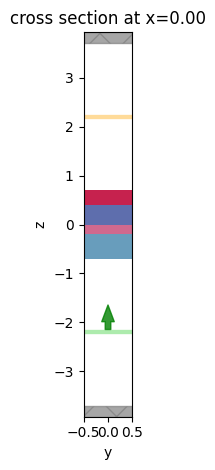

In [9]:
sim.plot(x=0)
plt.show()


Next, we use `Simulation.plot_eps()` to vizualize the permittivity of the stack. However, because the stack contains dispersive materials, we need to specify the `freq` of interest as an argument to the plotting tool.  Here we show the permittivity at the lowest and highest frequences in the range of interest.  Note that in this case, the real part of the permittivity (being plotted) only changes slightly between the two frequencies on the dispersive material.  However, for other materials with more dispersion, the effect can be much more prominent.

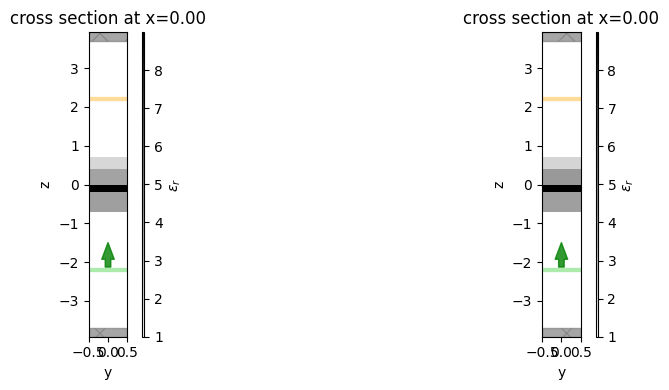

In [10]:
# plot the permittivity at a few frequencies
freqs_plot = (freq_range[0], freq_range[1])
fig, axes = plt.subplots(1, len(freqs_plot), tight_layout=True, figsize=(12, 4))
for ax, freq_plot in zip(axes, freqs_plot):
    sim.plot_eps(x=0, freq=freq_plot, ax=ax)
plt.show()


We can also take a look at the source to make sure it's defined correctly over our frequency range of interst.

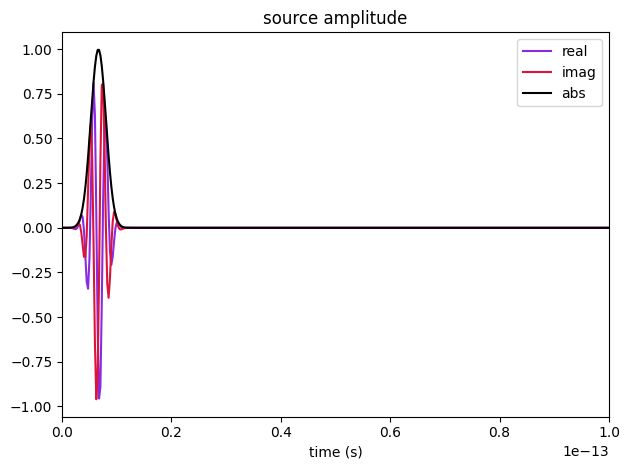

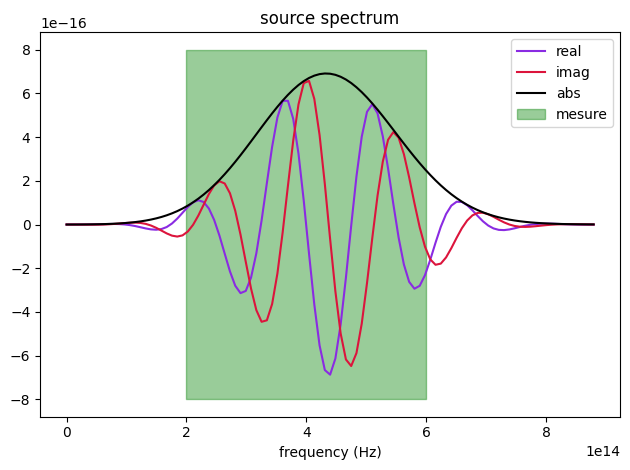

In [11]:
# Check probe and source
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, sim.run_time, 1001))
ax1.set_xlim(0, 1e-13)
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 1001))
ax2.fill_between(
    freq_range, [-8e-16, -8e-16], [8e-16, 8e-16], alpha=0.4, color="g", label="mesure"
)
ax2.legend()
plt.show()


## Run the simulation

We will submit the simulation to run as a new project.

In [12]:
sim_data = web.run(sim, task_name="dispersion", path="data/sim_data.hdf5")


[09:48:19] INFO     Using Tidy3D credentials from stored file.                     ]8;id=376602;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=718058;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#77\77]8;;\

[09:48:31] INFO     Authentication successful.                                     ]8;id=315470;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=221404;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#37\37]8;;\

           INFO     Created task 'dispersion' with task_id                      ]8;id=488239;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=85482;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\
                    'b6584f00-2442-41e7-a8ff-c71ef0a3d148'.                                  

Output()

[09:48:32] INFO     status = queued                                             ]8;id=762417;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236262;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

Output()

[09:48:41] INFO     status = preprocess                                         ]8;id=232358;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=709068;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#275\275]8;;\

[09:48:45] INFO     Maximum FlexUnit cost: 0.106. Use 'web.real_cost(task_id)'  ]8;id=665207;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=373999;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#299\299]8;;\
                    to get the billed FlexUnit cost after a simulation run.                  

           INFO     starting up solver                                          ]8;id=908996;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=537401;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#303\303]8;;\

[09:48:56] INFO     running solver                                              ]8;id=933749;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=937942;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#313\313]8;;\

Output()

[09:49:11] INFO     early shutoff detected, exiting.                            ]8;id=504566;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177080;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#326\326]8;;\

           INFO     status = postprocess                                        ]8;id=444921;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=314578;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\

Output()

[09:49:13] INFO     status = success                                            ]8;id=641061;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=23517;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#350\350]8;;\

[09:49:14] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=923357;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981679;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#673\673]8;;\
                    "data/sim_data.hdf5"                                                     

Output()

           INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=736779;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=657524;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#472\472]8;;\

## Postprocess and Plot

Once the simulation has completed, we can download the results and load them into the simulation object.

Now, we compute the transmitted flux and plot the transmission spectrum.

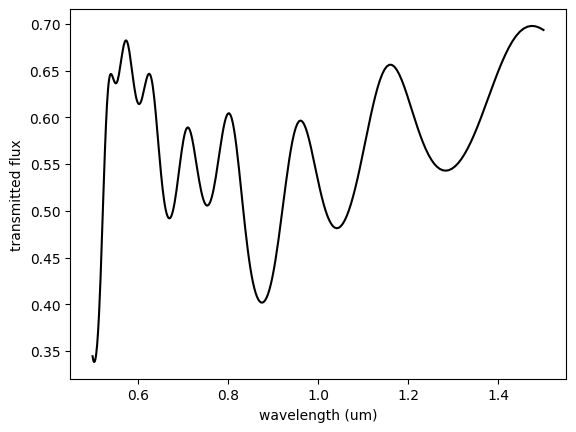

In [13]:
# Retrieve the power flux through the monitor plane.
transmission = sim_data["flux"].flux
plt.plot(monitor_lambdas, transmission, color="k")
plt.xlabel("wavelength (um)")
plt.ylabel("transmitted flux")
plt.show()


In Tidy3D, results are normalized by default. In some cases, and largely depending on the required accuracy, a normalizing run may still be needed. Here, we show how to do such a normalizing run by simulating an empty simulation with the exact same source and monitor but none of the structures.

In [14]:
sim_norm = sim.copy(update={"structures": []})

sim_data_norm = web.run(
    sim_norm, task_name="docs_dispersion_norm", path="data/sim_data.hdf5"
)
transmission_norm = sim_data_norm["flux"].flux


           INFO     Auto meshing using wavelength 0.7500 defined from        ]8;id=170458;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=285946;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

           INFO     Created task 'docs_dispersion_norm' with task_id            ]8;id=75370;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=967808;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\
                    'bfe9c840-2213-4722-803c-f77df5ec7d79'.                                  

Output()

[09:49:16] INFO     status = queued                                             ]8;id=684228;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=605882;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

Output()

[09:49:18] INFO     status = preprocess                                         ]8;id=591462;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=152903;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#275\275]8;;\

[09:49:21] INFO     Maximum FlexUnit cost: 0.025. Use 'web.real_cost(task_id)'  ]8;id=231932;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=995682;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#299\299]8;;\
                    to get the billed FlexUnit cost after a simulation run.                  

           INFO     starting up solver                                          ]8;id=119670;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=394276;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#303\303]8;;\

[09:49:27] INFO     running solver                                              ]8;id=943546;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=993546;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#313\313]8;;\

Output()

[09:49:28] INFO     early shutoff detected, exiting.                            ]8;id=29075;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=815987;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#326\326]8;;\

[09:49:29] INFO     status = postprocess                                        ]8;id=544823;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=315248;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\

Output()

[09:49:30] INFO     status = success                                            ]8;id=240248;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=614220;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#350\350]8;;\

[09:49:31] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=886272;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=182994;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#673\673]8;;\
                    "data/sim_data.hdf5"                                                     

Output()

           INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=39475;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=320091;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#472\472]8;;\

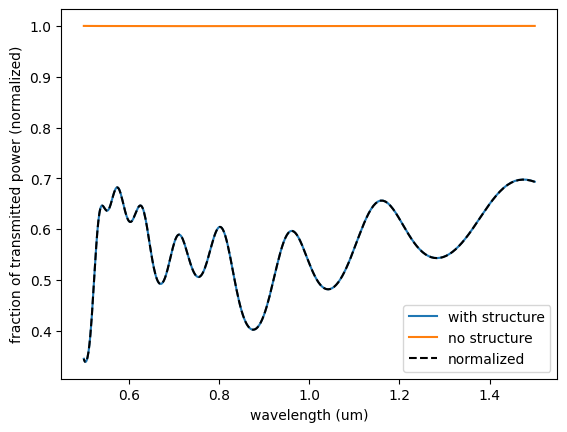

In [15]:
plt.plot(monitor_lambdas, transmission, label="with structure")
plt.plot(monitor_lambdas, transmission_norm, label="no structure")
plt.plot(monitor_lambdas, transmission / transmission_norm, "k--", label="normalized")
plt.legend()
plt.xlabel("wavelength (um)")
plt.ylabel("fraction of transmitted power (normalized)")
plt.show()


We see that since the flux monitor already takes the source power into account, the normalizing run has no visible effect on the results.

## Analytical Comparison

We will use a transfer matrix method (TMM) [code](https://github.com/sbyrnes321/tmm) to compare tidy3d transmission to a semi-analytical result.

In [16]:
# import TMM package
import tmm


In [17]:
# prepare list of thicknesses including air boundaries
d_list = [np.inf] + t_slabs + [np.inf]

# convert the complex permittivities at each frequency to refractive indices
n_list1 = np.sqrt(mat1.eps_model(monitor_freqs))
n_list2 = np.sqrt(mat2.eps_model(monitor_freqs))
n_list3 = np.sqrt(mat3.eps_model(monitor_freqs))
n_list4 = np.sqrt(mat4.eps_model(monitor_freqs))

# loop through wavelength and record TMM computed transmission
transmission_tmm = []
for i, lam in enumerate(monitor_lambdas):

    # create list of refractive index at this wavelength including outer material (air)
    n_list = [1, n_list1[i], n_list2[i], n_list3[i], n_list4[i], 1]

    # get transmission at normal incidence
    T = tmm.coh_tmm("s", n_list, d_list, 0, lam)["T"]
    transmission_tmm.append(T)


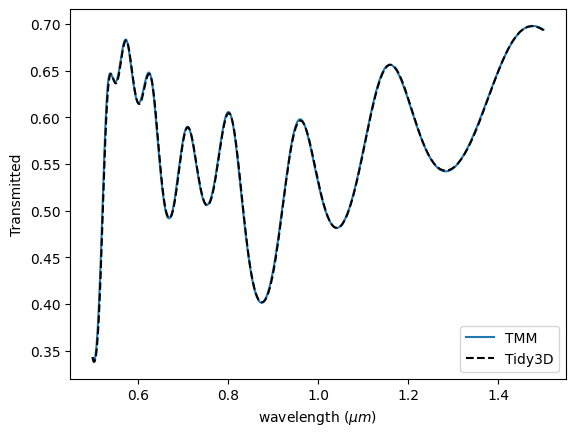

In [18]:
plt.figure()
plt.plot(monitor_lambdas, transmission_tmm, label="TMM")
plt.plot(monitor_lambdas, transmission / transmission_norm, "k--", label="Tidy3D")
plt.xlabel("wavelength ($\mu m$)")
plt.ylabel("Transmitted")
plt.legend()
plt.show()
